<a href="https://colab.research.google.com/github/Jlokkerbol/masterclass/blob/main/Optimizing_different_metrics_in_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimizing different metrics

This notebook shows how to optimize your machine learning models over different metrics, and how this results in different models with, therefore, a different impact on the processes you are trying to improve with your project.

In [1]:
#import relevant modules
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, StratifiedShuffleSplit, RepeatedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score

In [2]:
#load the Sonar data, containing 60 attributes, with the aim to classify 
# objects as Mine or Rock
# more information to be found at: https://datahub.io/machine-learning/sonar
df = pd.read_csv('https://datahub.io/machine-learning/sonar/r/sonar.csv')
df.head()

,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,attribute_6,attribute_7,attribute_8,attribute_9,attribute_10,attribute_11,attribute_12,attribute_13,attribute_14,attribute_15,attribute_16,attribute_17,attribute_18,attribute_19,attribute_20,attribute_21,attribute_22,attribute_23,attribute_24,attribute_25,attribute_26,attribute_27,attribute_28,attribute_29,attribute_30,attribute_31,attribute_32,attribute_33,attribute_34,attribute_35,attribute_36,attribute_37,attribute_38,attribute_39,attribute_40,attribute_41,attribute_42,attribute_43,attribute_44,attribute_45,attribute_46,attribute_47,attribute_48,attribute_49,attribute_50,attribute_51,attribute_52,attribute_53,attribute_54,attribute_55,attribute_56,attribute_57,attribute_58,attribute_59,attribute_60,Class
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,0.1609,0.1582,0.2238,0.0645,0.0660,0.2273,0.3100,0.2999,0.5078,0.4797,0.5783,0.5071,0.4328,0.5550,0.6711,0.6415,0.7104,0.8080,0.6791,0.3857,0.1307,0.2604,0.5121,0.7547,0.8537,0.8507,0.6692,0.6097,0.4943,0.2744,0.0510,0.2834,0.2825,0.4256,0.2641,0.1386,0.1051,0.1343,0.0383,0.0324,0.0232,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,Rock
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,0.4918,0.6552,0.6919,0.7797,0.7464,0.9444,1.0000,0.8874,0.8024,0.7818,0.5212,0.4052,0.3957,0.3914,0.3250,0.3200,0.3271,0.2767,0.4423,0.2028,0.3788,0.2947,0.1984,0.2341,0.1306,0.4182,0.3835,0.1057,0.1840,0.1970,0.1674,0.0583,0.1401,0.1628,0.0621,0.0203,0.0530,0.0742,0.0409,0.0061,0.0125,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,Rock
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,0.6333,0.7060,0.5544,0.5320,0.6479,0.6931,0.6759,0.7551,0.8929,0.8619,0.7974,0.6737,0.4293,0.3648,0.5331,0.2413,0.5070,0.8533,0.6036,0.8514,0.8512,0.5045,0.1862,0.2709,0.4232,0.3043,0.6116,0.6756,0.5375,0.4719,0.4647,0.2587,0.2129,0.2222,0.2111,0.0176,0.1348,0.0744,0.0130,0.0106,0.0033,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,Rock
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,0.0881,0.1992,0.0184,0.2261,0.1729,0.2131,0.0693,0.2281,0.4060,0.3973,0.2741,0.3690,0.5556,0.4846,0.3140,0.5334,0.5256,0.2520,0.2090,0.3559,0.6260,0.7340,0.6120,0.3497,0.3953,0.3012,0.5408,0.8814,0.9857,0.9167,0.6121,0.5006,0.3210,0.3202,0.4295,0.3654,0.2655,0.1576,0.0681,0.0294,0.0241,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,Rock
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,0.4152,0.3952,0.4256,0.4135,0.4528,0.5326,0.7306,0.6193,0.2032,0.4636,0.4148,0.4292,0.5730,0.5399,0.3161,0.2285,0.6995,1.0000,0.7262,0.4724,0.5103,0.5459,0.2881,0.0981,0.1951,0.4181,0.4604,0.3217,0.2828,0.2430,0.1979,0.2444,0.1847,0.0841,0.0692,0.0528,0.0357,0.0085,0.0230,0.0046,0.0156,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,Rock


# Data splitting

As always, we start the machine learning pipeline by splitting the data. We use sklearn's StratifiedShuffleSplit to ensure that the distribution of our outcome is similar in both the training and the test set. The objects X and y are assigned the predictors and outcomes in the training (_train) and test (_test) set, respectively.

In [3]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, test_index in split.split(df, df['Class']):
  strat_train_set = df.loc[train_index]
  strat_test_set = df.loc[test_index]

In [4]:
#check if this resulted in a 70% train set and 30% test set with equal outcome distributions
print('share of observations in the train set:', str(round(len(strat_train_set)/len(df), 3)))
print('share of observations in the test set:', str(round(len(strat_test_set)/len(df), 3)))
print('share of mines in the train set:', str(round(len(strat_train_set.loc[strat_train_set['Class'] == 'Mine'])/len(strat_train_set), 3)))
print('share of mines in the test set:', str(round(len(strat_test_set.loc[strat_test_set['Class'] == 'Mine'])/len(strat_test_set), 3)))

share of observations in the train set: 0.697
share of observations in the test set: 0.303
share of mines in the train set: 0.531
share of mines in the test set: 0.54


In [5]:
# split features and outcome data
X_train = strat_train_set.loc[:,strat_train_set.columns != 'Class']
y_train = strat_train_set['Class']
X_test = strat_test_set.loc[:,strat_test_set.columns != 'Class']
y_test = strat_test_set['Class']

In [6]:
sc = StandardScaler()
X_train_prep = sc.fit_transform(X_train)
X_train_prep = pd.DataFrame(data = X_train_prep, columns = X_train.columns)
X_train_prep.head()


,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,attribute_6,attribute_7,attribute_8,attribute_9,attribute_10,attribute_11,attribute_12,attribute_13,attribute_14,attribute_15,attribute_16,attribute_17,attribute_18,attribute_19,attribute_20,attribute_21,attribute_22,attribute_23,attribute_24,attribute_25,attribute_26,attribute_27,attribute_28,attribute_29,attribute_30,attribute_31,attribute_32,attribute_33,attribute_34,attribute_35,attribute_36,attribute_37,attribute_38,attribute_39,attribute_40,attribute_41,attribute_42,attribute_43,attribute_44,attribute_45,attribute_46,attribute_47,attribute_48,attribute_49,attribute_50,attribute_51,attribute_52,attribute_53,attribute_54,attribute_55,attribute_56,attribute_57,attribute_58,attribute_59,attribute_60
0,0.034283,0.067601,-0.540083,-1.216550,-1.170987,-0.701419,-0.516137,-0.268162,-0.688366,-0.999476,-1.452884,-0.924677,-0.671054,-0.604662,-0.310763,-0.702617,-0.645532,-0.649335,-0.729284,-0.317455,-0.299591,-0.008835,0.131029,0.311613,0.712183,0.849213,1.234418,0.990376,0.336450,0.242650,0.499052,0.119935,-0.673320,-1.005238,-0.880116,-0.472645,-0.376587,-0.094161,-0.227435,-0.676225,-0.813205,-0.203893,-0.267677,-0.296704,-0.355767,-0.682982,-0.169889,-0.020404,-0.357189,-0.867054,-0.652782,-0.663675,-0.450920,-0.007605,-0.567176,0.293379,-0.654754,-0.351269,-0.475797,0.409389
1,1.858457,0.744916,1.373396,-0.358238,-0.523457,-0.436807,-0.715491,-0.240968,0.468459,-0.183085,0.374547,1.164771,0.629917,-0.636518,-0.257037,0.016645,0.500725,0.756393,0.350793,-0.337814,-1.158652,-1.704743,-1.792821,-2.119814,-1.763306,-1.824993,-1.582754,-0.814761,0.300458,0.757940,1.346200,1.664721,1.237655,1.244888,1.375219,1.686245,2.300661,3.170289,2.803381,2.246552,2.196068,1.719033,1.492587,1.048330,-0.343992,-0.310525,0.067050,0.417722,0.143261,0.217290,-0.202379,0.072554,1.193419,-0.903566,-0.777689,-0.962169,-0.960487,1.190439,0.430963,0.258869
2,-0.413156,-0.874452,-0.317661,-0.726481,0.165531,0.824675,-0.099744,-0.858148,-0.399998,-0.534576,-1.206989,-1.597307,-1.022537,-0.021406,1.047592,1.663665,1.408736,1.217317,1.329867,1.193420,1.298597,1.248310,1.178522,1.341047,1.214272,1.009183,1.000330,0.258084,-0.726925,-1.127596,-0.410590,0.107458,-0.071446,-0.454020,-0.570032,-0.939609,-0.460671,-0.552751,-0.793482,-0.899058,-1.218376,-1.316296,-1.160146,-0.691140,-0.554093,-0.760258,-0.902746,-0.796152,-0.805106,-1.531405,0.202221,-0.063067,-0.325504,-0.572750,-0.679450,-0.317875,-0.510879,-0.365677,-0.122315,-0.211507
3,0.181790,-0.884766,-0.405976,0.173362,0.072745,-0.125597,-0.363406,-0.373390,-0.640584,0.054246,0.543161,0.661013,0.176234,-0.973614,-1.020131,-1.032105,-0.926566,-0.833340,-1.183992,-1.302128,-1.148293,-0.131912,0.729596,0.943510,1.281299,1.269187,1.039683,1.339393,1.141080,0.730304,1.223526,1.265470,0.549450,-0.828538,-1.167940,-0.959243,-1.059660,-1.047394,-0.708022,-1.542171,-0.807474,-1.171051,-0.952890,-0.375005,-0.677426,-1.101387,-0.501603,0.507231,0.334040,-0.210338,-0.843631,-0.702424,-0.158283,0.364563,-0.398765,-0.350915,-0.780644,-0.682664,-0.291371,0.033088
4,0.403051,0.153555,-0.343828,-0.576969,0.191196,0.513465,-0.088490,-0.793119,-1.374078,-1.183483,-1.157810,0.031317,-0.877524,-1.048910,-1.025836,-0.975586,-1.099538,-1.250176,-1.285769,-1.795052,-1.627630,-2.421627,-1.663861,-1.761406,-2.686063,-2.175546,-0.865073,0.131535,0.234472,0.298369,0.932810,0.459575,1.182052,2.005991,2.186749,2.239056,1.780555,1.618582,1.636097,2.054182,1.755938,1.295830,0.917346,0.052361,-0.325399,-0.599440,-0.486175,-0.282651,0.110082,-0.240883,-0.790193,-0.411807,0.775367,0.709164,-0.146149,-0.235273,1.035773,-0.178367,-0.045470,0.051904


In [7]:
X_test_prep = sc.transform(X_test)
X_test_prep = pd.DataFrame(data = X_test_prep, columns = X_test.columns)
X_test_prep.head(5)

,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,attribute_6,attribute_7,attribute_8,attribute_9,attribute_10,attribute_11,attribute_12,attribute_13,attribute_14,attribute_15,attribute_16,attribute_17,attribute_18,attribute_19,attribute_20,attribute_21,attribute_22,attribute_23,attribute_24,attribute_25,attribute_26,attribute_27,attribute_28,attribute_29,attribute_30,attribute_31,attribute_32,attribute_33,attribute_34,attribute_35,attribute_36,attribute_37,attribute_38,attribute_39,attribute_40,attribute_41,attribute_42,attribute_43,attribute_44,attribute_45,attribute_46,attribute_47,attribute_48,attribute_49,attribute_50,attribute_51,attribute_52,attribute_53,attribute_54,attribute_55,attribute_56,attribute_57,attribute_58,attribute_59,attribute_60
0,1.199591,1.810742,5.151290,5.821607,4.939095,2.019589,-0.963077,1.126995,-0.707646,-1.007737,-0.608254,-0.196948,-0.021950,0.163359,0.420952,0.060605,0.434727,0.803396,1.303165,1.375477,1.202172,1.486872,1.228402,0.966821,0.643511,0.036431,-0.142523,-0.884081,-1.511158,-1.673198,-1.667423,-1.563942,-1.301045,-0.716053,0.201273,0.475141,0.362831,0.560555,0.377321,-0.100809,0.250442,1.201848,0.797504,-0.599666,-0.153104,-0.252742,-0.795848,-0.180578,-0.158115,-0.706693,1.049589,1.070338,1.318835,2.046213,-0.132115,1.102877,1.683209,0.959903,0.815183,-0.173877
1,0.152289,2.054851,2.940159,2.510185,1.877144,1.125900,-0.779799,0.079445,0.242124,1.074922,-0.470865,-1.318953,-1.534224,0.387510,0.969143,0.603192,0.251601,-0.165455,-1.221143,-0.582514,0.625214,1.380977,1.170816,-0.507604,-0.618495,-0.061448,-0.475602,-0.502822,-1.624334,-1.615696,0.353232,0.898566,-0.591379,-0.939730,-0.370859,0.529036,1.104850,0.422113,1.157521,1.723036,1.172537,-0.286483,-0.383289,-0.334757,-0.460508,-0.741461,-0.133522,0.180600,-0.053048,-0.363063,0.255658,0.653788,2.001654,0.309427,-0.300526,0.888112,0.262447,0.916677,-0.690960,0.710429
2,-0.418073,0.222318,0.431376,0.779718,-0.203640,-0.270385,-0.024182,1.623576,-0.493047,-1.353971,-0.107876,0.081407,-0.666220,0.362604,0.547896,0.650501,0.057960,-0.334886,-0.669301,-1.196418,-1.497734,-2.058789,-1.600598,-0.669949,-1.230788,-1.244618,-0.621654,-0.628968,-0.677735,-0.675602,-0.545763,-0.203070,0.235832,-0.034249,-0.673523,-0.759445,-1.118606,-0.623415,0.038497,0.348806,-0.033808,0.074066,0.043911,-0.204498,0.009275,0.061931,-0.445399,0.161756,0.317451,-0.408880,-0.614612,0.556915,1.081939,0.709164,2.787001,0.095135,2.960097,2.083764,1.675836,0.578724
3,-0.536079,-0.200574,-0.438685,-0.297325,-0.183898,-0.844543,-0.848930,-0.828590,-0.980925,-1.103120,-0.553610,0.697507,1.261067,1.219243,1.391817,1.340457,0.252689,-0.327234,-0.981212,-0.930184,-0.513560,0.139417,0.359344,1.013443,1.327355,0.336966,-0.524286,-0.203376,0.958318,0.364786,-0.128670,0.279358,-0.413353,-0.421266,-0.407179,-0.601609,-1.217859,-1.346872,-1.069468,-1.394932,-0.825812,-1.080487,-0.604644,-0.223525,-0.582602,0.177497,0.244478,-0.847973,-0.470551,0.484558,0.049542,-0.305248,0.245834,-0.889782,-0.230355,0.656827,0.388338,-0.322452,-0.752436,-0.870033
4,-0.963850,-1.018854,-0.553166,-0.034294,0.935461,0.924529,0.282888,-0.410042,-0.703455,-0.140275,-0.384996,0.032748,0.924085,-0.055000,-0.228035,0.555465,-0.157439,-1.145967,-0.834157,-0.710150,-1.040711,-0.735710,-0.036051,-0.906390,-0.313788,0.742280,0.592197,0.399948,-0.462981,-0.514239,0.153712,0.460499,-0.162654,-0.195003,1.360379,1.529178,0.110146,-1.316107,0.255163,1.712317,0.308897,-0.323506,-0.215511,0.618036,-0.068196,-0.064077,-0.844338,-0.618704,-1.051184,-1.057959,0.194587,-0.721799,-0.130413,1.177820,-0.160184,1.119397,1.449413,-0.380086,1.660467,0.691614


# Running models with different metrics

Each time, we run a simple LASSO model, using the same grid of lasso penalties.

In [8]:
lasso_alphas = np.linspace(0.2, 10, 50)
grid = dict()
grid['C'] = lasso_alphas

### Accuracy

In [9]:
clf_acc = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)

gscv_acc = GridSearchCV(clf_acc, grid, scoring='accuracy', cv = cv, n_jobs=-1)
results_acc = gscv_acc.fit(X_train_prep, y_train)

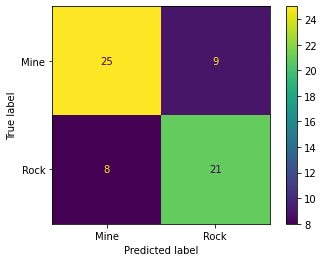

In [10]:
cm_acc = confusion_matrix(y_test, results_acc.best_estimator_.predict(X_test_prep), labels=results_acc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_acc, display_labels=results_acc.classes_)
disp.plot()

### Recall / Sensitivity

In [11]:
clf_rec = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)

gscv_rec = GridSearchCV(clf_rec, grid, scoring='recall', cv = cv, n_jobs=-1)
results_rec = gscv_rec.fit(X_train_prep, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  category=UserWarning,


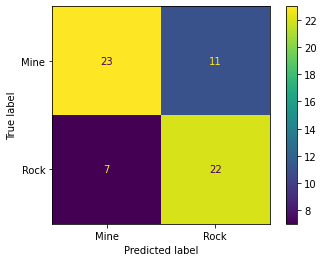

In [12]:
cm_rec = confusion_matrix(y_test, results_rec.best_estimator_.predict(X_test_prep), labels=results_rec.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rec, display_labels=results_rec.classes_)
disp.plot()

### AUC / AUROC / ROC_AUC

In [13]:
clf_auc = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)

gscv_auc = GridSearchCV(clf_auc, grid, scoring='roc_auc', cv = cv, n_jobs=-1)
results_auc = gscv_auc.fit(X_train_prep, y_train)

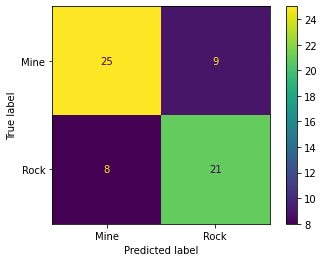

In [14]:
cm_auc = confusion_matrix(y_test, results_auc.best_estimator_.predict(X_test_prep), labels=results_auc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_auc, display_labels=results_auc.classes_)
disp.plot()

### Precision / Positive Predictive Value

In [15]:
clf_ppv = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)

gscv_ppv = GridSearchCV(clf_ppv, grid, scoring='precision', cv = cv, n_jobs=-1)
results_ppv = gscv_ppv.fit(X_train_prep, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  category=UserWarning,


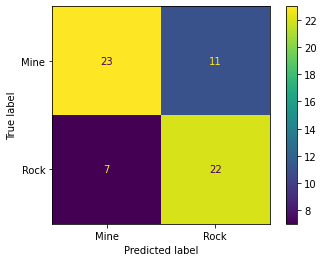

In [16]:
cm_ppv = confusion_matrix(y_test, results_ppv.best_estimator_.predict(X_test_prep), labels=results_ppv.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_ppv, display_labels=results_ppv.classes_)
disp.plot()

### F1-score

In [17]:
clf_f1 = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)

gscv_f1 = GridSearchCV(clf_f1, grid, scoring='f1', cv = cv, n_jobs=-1)
results_f1 = gscv_f1.fit(X_train_prep, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  category=UserWarning,


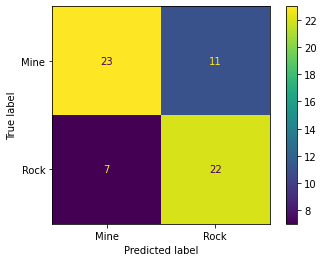

In [18]:
cm_f1 = confusion_matrix(y_test, results_f1.best_estimator_.predict(X_test_prep), labels=results_f1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_f1, display_labels=results_f1.classes_)
disp.plot()

# To conclude

This notebook presented a range of commonly applied performance metrics. There are many more built-in options, which can be viewed at https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter. 

In case you have a very specific metric in mind that is not readily available, you can define a custom loss function, described at https://scikit-learn.org/stable/modules/model_evaluation.html#scoring.

Please be aware that it is a very common mistake to optimize over the wrong performance metric, and that this will impact the model you end up with and the impact you are able to make in the process you set out to improve.